# predict_T+1_tf2
## Base
### 依赖与超参数

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, BatchNormalization, \
    Flatten, Lambda, Permute, RepeatVector
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow_model_optimization as tfmot
import tempfile
import zipfile
import os
import matplotlib.pyplot as plt

In [4]:
SINGLE_ATTENTION_VECTOR = False
INPUT_DIMS = 4
TIME_STEPS = 20
lstm_units = 64
epoch = 30
dropout = 0.3
temperature = 10  # 蒸馏温度
alpha = 0.1  # 蒸馏损失和学生损失的权重

### 模型相关函数

In [5]:
def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: tf.reduce_mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul


# 多维归一化 返回数据和最大最小值
def NormalizeMult(data):
    normalize = np.arange(2 * data.shape[1], dtype='float64')

    normalize = normalize.reshape(data.shape[1], 2)
    for i in range(0, data.shape[1]):
        list = data[:, i]
        list_low, list_high = np.percentile(list, [0, 100])
        normalize[i, 0] = list_low
        normalize[i, 1] = list_high
        delta = list_high - list_low
        if delta != 0:
            for j in range(0, data.shape[0]):
                data[j, i] = (data[j, i] - list_low) / delta
    return data, normalize


# 多维反归一化
def FNormalizeMult(data, normalize):
    data = np.array(data)
    for i in range(0, data.shape[1]):
        listlow = normalize[i, 0]
        listhigh = normalize[i, 1]
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0, data.shape[0]):
                data[j, i] = data[j, i] * delta + listlow

    return data

# 模型评估
def calculate_metrics(test_Y, pred_Y):
    mae = mean_absolute_error(test_Y, pred_Y)
    mse = mean_squared_error(test_Y, pred_Y)

    test_diff = np.diff(test_Y[:, 1])
    pred_diff = np.diff(pred_Y[:, 1])
    test_sign = np.sign(test_diff)
    pred_sign = np.sign(pred_diff)
    accuracy = np.mean(test_sign == pred_sign) * 100

    return mae, mse, accuracy

# 预测第二天价格-数据集创建
def create_dataset_tomorrow(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)
    return TrainX, Train_Y

### 数据加载与划分

In [6]:
# 加载数据
data = pd.read_csv("./data.csv")
data = data[['open', 'close', 'high', 'low']]

# 归一化
data = np.array(data)
data, normalize = NormalizeMult(data)
close_column = data[:, 1].reshape(len(data), 1)

train_X, train_Y = create_dataset_tomorrow(data, TIME_STEPS)
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)



## 直接训练并运行

In [5]:
def attention_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='linear')(attention_mul)  # Output layer adjusted for 4 features
    model = Model(inputs=[inputs], outputs=output)
    return model

def attention_model_with_norm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [6]:
m = attention_model()

m.summary()
m.compile(optimizer='adam', loss='mse')
m.fit([train_X], train_Y, epochs=epoch, batch_size=64, validation_split=0.1)
# 使用测试集进行预测
pred_Y = m.predict(test_X)

pred_Y_denormalized = FNormalizeMult(pred_Y, normalize)
test_Y_denormalized = FNormalizeMult(test_Y, normalize)

# 使用示例
mae, mse, accuracy = calculate_metrics(test_Y, pred_Y)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"涨跌准确率: {accuracy}%")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 20, 64)    │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 20, 64)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 20, 128)   │     66,048 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20, 128)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20, 128)   │     16,512 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_vec       │ (None, 20, 128)   │          0 │ dense[0][0]       │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 20, 128)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ attention_vec[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2560)      │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │     10,244 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,124 (363.77 KB)

 Trainable params: 93,124 (363.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
270/296 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0837

KeyboardInterrupt: 

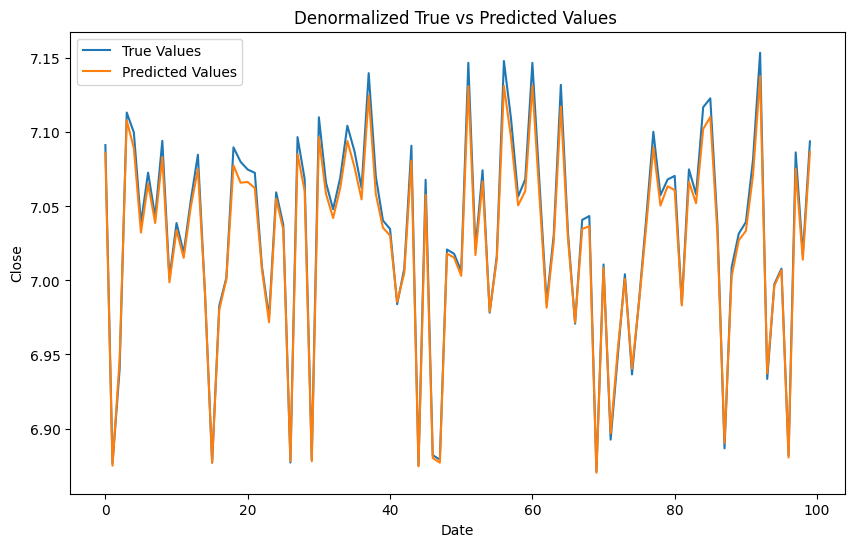

In [ ]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y_denormalized[:100, 1], label='True Values')
plt.plot(pred_Y_denormalized[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values ')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

## 蒸馏

In [6]:
temperature = 10  # 蒸馏温度
alpha = 0.1  # 蒸馏损失和学生损失的权重

In [7]:
# 蒸馏模型类
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data

        # 教师模型输出
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # 学生模型输出
            student_predictions = self.student(x, training=True)

            # 计算学生的损失
            student_loss = self.student_loss_fn(y, student_predictions)

            # 计算蒸馏损失（使用温度处理的softmax）
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )

            # 总损失
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # 计算梯度并更新学生模型的权重
        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        # 更新metrics
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def call(self, inputs):
        # 在这里，我们定义了Distiller的call方法，即通过学生模型进行前向传播
        student_predictions = self.student(inputs, training=False)
        return student_predictions

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [8]:
# 教师模型与上面的attention_model()是一样的
def teacher_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='linear')(attention_mul)  # 教师模型输出4个特征
    model = Model(inputs=[inputs], outputs=output)
    return model

# 32 /3
# 定义学生模型
def student_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=32, kernel_size=1, activation='relu')(inputs)  # 较少的过滤器
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units // 3, return_sequences=True))(x)  # 更少的LSTM单元
    lstm_out = Dropout(dropout)(lstm_out)
    # attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(lstm_out)
    output = Dense(4, activation='linear')(attention_mul)  # 学生模型输出4个特征
    model = Model(inputs=[inputs], outputs=output)
    return model

In [19]:
# 创建教师模型和学生模型
teacher = teacher_model()
student = student_model()

# 训练教师模型
teacher.compile(optimizer='adam', loss='mse')
teacher.fit([train_X], train_Y, epochs=epoch, batch_size=64, validation_split=0.1)

# 创建蒸馏模型并训练学生模型
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer='adam',
    metrics=['mae'],
    student_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=alpha,
    temperature=temperature
)

# 训练蒸馏模型
distiller.fit(train_X, train_Y, epochs=epoch, batch_size=64, validation_split=0.1)

# 使用测试集进行预测
pred_Y = distiller.predict(test_X)
pred_Y_denormalized = FNormalizeMult(pred_Y, normalize)
test_Y_denormalized = FNormalizeMult(test_Y, normalize)

# 计算评价指标
mae, mse, accuracy = calculate_metrics(test_Y, pred_Y)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"涨跌准确率: {accuracy}%")


Epoch 1/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0597 - val_loss: 0.0238
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0026 - val_loss: 0.0088
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 6/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0011 - val_loss: 8.4378e-04
Epoch 7/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0011 - val_loss: 2.7812e-04
Epoch 8/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 9.4839e-04 - val_loss: 0.0018
Epoch 9/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 8.8823e-04 - val_loss: 0.0011
Epoch 10/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 9.0121e-04 - val_loss: 7.9623e-04
Epoch 11/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 7.1725e-04 - val_loss: 6.8870e-04
Epoch 12/

d:\IDE-Extends\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:592: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


296/296 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - mae: 0.0962 - distillation_loss: 2.1114e-05 - loss: 0.5085 - student_loss: 0.0090 - val_mae: 0.0113 - val_loss: 0.5358 - val_student_loss: 2.3707e-04
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - mae: 0.0369 - distillation_loss: 4.3051e-06 - loss: 0.5333 - student_loss: 0.0021 - val_mae: 0.0106 - val_loss: 0.5435 - val_student_loss: 2.0427e-04
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - mae: 0.0294 - distillation_loss: 2.1490e-06 - loss: 0.5327 - student_loss: 0.0014 - val_mae: 0.0126 - val_loss: 0.5326 - val_student_loss: 2.9596e-04
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - mae: 0.0258 - distillation_loss: 1.3262e-06 - loss: 0.5310 - student_loss: 0.0011 - val_mae: 0.0097 - val_loss: 0.5357 - val_student_loss: 1.8678e-04
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - mae: 0.0231 - distillation_loss: 9.1074e-07 - loss: 0.5356 - student_loss: 9.0908e-04 - val_mae: 0.0175 - val_loss: 0.5249 - val_student

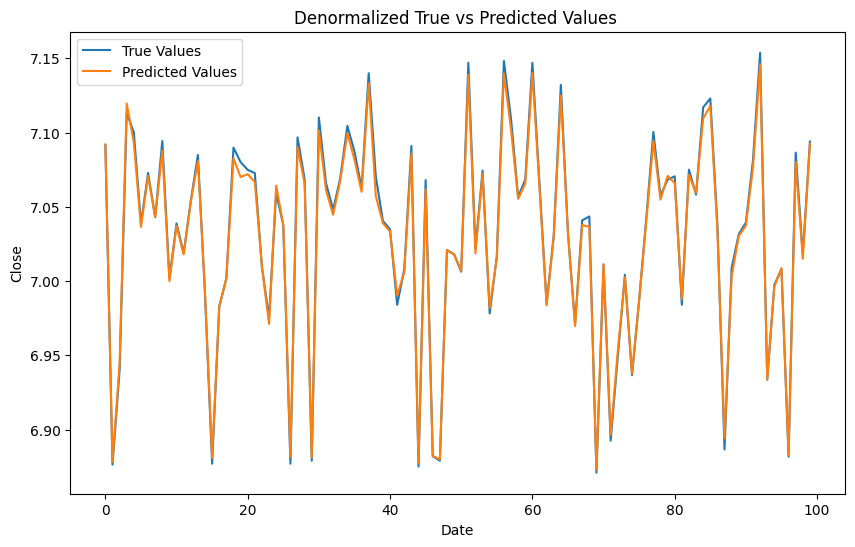

In [20]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y_denormalized[:100, 1], label='True Values')
plt.plot(pred_Y_denormalized[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values ')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
teacher.summary()
student.summary()

<class 'keras.src.models.functional.Functional'>


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 20, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 20, 32)         │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 20, 42)         │         9,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 20, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 840)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         3,364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,596 (49.20 KB)

 Trainable params: 12,596 (49.20 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model):
    # Convert the model to a concrete function
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]))
    )
    # Freeze the concrete function to get a static graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # Use the TensorFlow v1 profiler to calculate FLOPs
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(
            graph=graph, run_meta=run_meta, cmd="op", options=opts
        )
        return flops.total_float_ops if flops is not None else 0

# Initialize models with sample input to ensure they are built
sample_input = tf.random.normal([1, TIME_STEPS, INPUT_DIMS])
teacher(sample_input)
student(sample_input)

# Calculate FLOPs
teacher_flops = get_flops(teacher)
student_flops = get_flops(student)

print(f"教师模型 FLOPs: {teacher_flops}")
print(f"学生模型 FLOPs: {student_flops}")

教师模型 FLOPs: 779652
学生模型 FLOPs: 23236


## 剪枝

### 量化学生模型（转为 TFLite 模型）

In [1]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [2]:
# 创建并保存简单模型示例
simple_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(1)
])

simple_model.compile(optimizer='adam', loss='mse')
dummy_input = np.random.rand(1, 4).astype(np.float32)
simple_model(dummy_input)  # 确保模型可以运行
tf.saved_model.save(simple_model, './simple_model')

d:\IDE-Extends\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

In [ ]:
outfile = 'studentSavedModel'
folder = os.path.join(os.getcwd(), outfile)
exist = os.path.exists(folder)
if not exist:  
    os.makedirs(folder)
else:
    os.rmdir(folder)
    os.mkdir(folder)

tf.saved_model.save(student,folder)
converter = tf.lite.TFLiteConverter.from_saved_model('studentSavedModel')

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

In [ ]:
# 启用量化
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

# 提供代表性数据集
def representative_data_gen():
    for input_value in train_X[:100]:
        # 确保数据类型为 FLOAT32
        yield [input_value.astype(np.float32)]

converter.representative_dataset = representative_data_gen

# 设置输入输出数据类型
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# 转换为量化的 TFLite 模型
tflite_model_quant = converter.convert()

# 保存量化后的模型
import pathlib
tflite_models_dir = pathlib.Path("/tmp/student_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_quant_file = tflite_models_dir/"student_model_quant.tflite"
tflite_model_float_file = tflite_models_dir/"student_model_float.tflite"
size_quant = tflite_model_quant_file.write_bytes(tflite_model_quant)
size_float = tflite_model_float_file.write_bytes(student)

print(f"Quantized model size: {size_quant} bytes")
print(f"Float model size: {size_float} bytes")


INFO:tensorflow:Assets written to: C:\Users\21343\AppData\Local\Temp\tmp97wza9f4\assets


INFO:tensorflow:Assets written to: C:\Users\21343\AppData\Local\Temp\tmp97wza9f4\assets


Saved artifact at 'C:\Users\21343\AppData\Local\Temp\tmp97wza9f4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 4), dtype=tf.float32, name='keras_tensor_50')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2163770349648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163770351760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163769907280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163769913040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163769916304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163769911120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163769910736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163769909392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163769908624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2163769907088: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\21343\AppData\Roaming\Python\Python312\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


RuntimeError: tensorflow/lite/kernels/conv.cc:346 input->dims->size != 4 (3 != 4)Node number 2 (CONV_2D) failed to prepare.

### 进行量化后模型的推理

In [ ]:
import numpy as np

def run_tflite_model(tflite_file, test_image_indices):
    global test_X, test_Y

    # 加载量化后的 TFLite 模型
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices), 4), dtype=float)  # 假设输出是4个特征

    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_X[test_image_index]

        # 量化输入数据
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        # 扩展维度并转换数据类型
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])

        # 将输入数据传入模型
        interpreter.set_tensor(input_details['index'], test_image)

        # 执行推理
        interpreter.invoke()

        # 获取输出
        output = interpreter.get_tensor(output_details['index'])[0]

        # 存储预测结果
        predictions[i] = output

    return predictions

# 用于评估量化后的模型
def evaluate_model(tflite_file, model_type):
    test_image_indices = range(test_X.shape[0])
    predictions = run_tflite_model(tflite_file, test_image_indices)

    mae, mse, accuracy = calculate_metrics(test_Y, predictions)

    print(f'{model_type} model evaluation results:')
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"涨跌准确率: {accuracy}%")

# 评估量化后的学生模型
evaluate_model(tflite_model_quant_file, model_type="Quantized Student")
